These jupyter can reproduced the results of figure2 in our papers.
you can use these functions we defined to evaluate the performance of each method with 10-X cross-validation.
If you want to use each method to analyse youe own data, please see the Tutorial.ipynb

In [ ]:
import numpy as np
import pandas as pd
import sys
import pickle
import os
import time as tm
from functools import partial
import scipy.stats as st
from scipy.stats import wasserstein_distance
import scipy.stats
import copy
from sklearn.model_selection import KFold
import pandas as pd
import multiprocessing
import matplotlib as mpl 
import matplotlib.pyplot as plt
import scanpy as sc
import warnings
warnings.filterwarnings('ignore')

from scipy.spatial import distance_matrix
from sklearn.metrics import matthews_corrcoef
from scipy import stats


from scipy.spatial.distance import cdist
import h5py
from scipy.stats import spearmanr

import time
import sys
import tangram as tg
from os.path import join
from IPython.display import display


In [15]:
def SpaGE_impute(K):
    print ('We run SpaGE for this data\n')
    sys.path.append("Extenrnal/SpaGE-master/")
    from SpaGE.main import SpaGE
    global RNA_data, Spatial_data, train_gene, predict_gene
    RNA_data = RNA_data.loc[(RNA_data.sum(axis=1) != 0)]
    RNA_data = RNA_data.loc[(RNA_data.var(axis=1) != 0)]
    train = np.array(train_gene[K])
    predict = np.array(predict_gene[K])
    pv = len(train)/2
    Spatial = Spatial_data[train]
    Img_Genes = SpaGE(Spatial, RNA_data.T, n_pv = int(pv), genes_to_predict = predict)
    result = Img_Genes[predict]
    return result

def gimVI_impute(K):
    print ('We run gimVI for this data\n')
    import scvi
    import scanpy as sc
    from scvi.model import GIMVI
    import torch
    from torch.nn.functional import softmax, cosine_similarity, sigmoid
    global RNA_data_adata, Spatial_data_adata, train_gene, predict_gene
    test_list = np.array(predict_gene[K])
    train_list = np.array(train_gene[K])
    Genes  = list(Spatial_data_adata.var_names)
    rand_gene_idx = [Genes.index(x) for x in test_list]
    n_genes = len(Genes)
    rand_train_gene_idx = sorted(set(range(n_genes)) - set(rand_gene_idx))
    rand_train_genes = np.array(Genes)[rand_train_gene_idx]
    rand_genes = np.array(Genes)[rand_gene_idx]
    spatial_data_partial = Spatial_data_adata[:, rand_train_genes]
    sc.pp.filter_cells(spatial_data_partial, min_counts= 0)
    seq_data = copy.deepcopy(RNA_data_adata)
    seq_data = seq_data[:, Genes]
    sc.pp.filter_cells(seq_data, min_counts = 0)
    scvi.data.setup_anndata(spatial_data_partial)
    scvi.data.setup_anndata(seq_data)
    model = GIMVI(seq_data, spatial_data_partial)
    model.train(200)
    _, imputation = model.get_imputed_values(normalized = False)
    imputed = imputation[:, rand_gene_idx]
    result = pd.DataFrame(imputed, columns = rand_genes)
    print (test_list ==  rand_genes)
    print (train_list ==  rand_train_genes)
    return result
                       
def novoSpaRc_impute(K):
    print ('We run novoSpaRc for this data\n')
    import novosparc as nc
    global RNA_data, Spatial_data, locations, train_gene, predict_gene
    test_list = np.array(predict_gene[K])
    train_list = np.array(train_gene[K])
    gene_names = np.array(RNA_data.index.values)
    dge = RNA_data.values
    dge = dge.T
    num_cells = dge.shape[0]
    print ('number of cells and genes in the matrix:', dge.shape)

    hvg = np.argsort(np.divide(np.var(dge, axis = 0),np.mean(dge, axis = 0) + 0.0001))
    dge_hvg = dge[:,hvg[-2000:]]

    num_locations = locations.shape[0]

    p_location, p_expression = nc.rc.create_space_distributions(num_locations, num_cells)
    cost_expression, cost_locations = nc.rc.setup_for_OT_reconstruction(dge_hvg,locations,num_neighbors_source = 5,num_neighbors_target = 5)

    insitu_matrix = np.array(Spatial_data[train_list])
    insitu_genes = np.array(Spatial_data[train_list].columns)
    test_genes = np.array(test_list)
    test_matrix = np.array(Spatial_data[test_list])

    markers_in_sc = np.array([], dtype='int')
    for marker in insitu_genes:
        marker_index = np.where(gene_names == marker)[0]
        if len(marker_index) > 0:
            markers_in_sc = np.append(markers_in_sc, marker_index[0])
    cost_marker_genes = cdist(dge[:, markers_in_sc]/np.amax(dge[:, markers_in_sc]),insitu_matrix/np.amax(insitu_matrix))
    alpha_linear = 0.5
    gw = nc.rc._GWadjusted.gromov_wasserstein_adjusted_norm(cost_marker_genes, cost_expression, cost_locations,alpha_linear, p_expression, p_location,'square_loss', epsilon=5e-3, verbose=True)
    sdge = np.dot(dge.T, gw)
    imputed = pd.DataFrame(sdge,index = RNA_data.index)
    result = imputed.loc[test_genes]
    result = result.T
    return result
                       
def SpaOTsc_impute(K):
    print ('We run SpaOTsc for this data\n')
    from spaotsc import SpaOTsc
    global RNA_data, Spatial_data, locations, train_gene, predict_gene
    test_list = np.array(predict_gene[K])
    train_list = np.array(train_gene[K])
    df_sc = RNA_data.T
    df_IS = Spatial_data
    pts = locations
    is_dmat = distance_matrix(pts, pts)
    df_is = df_IS.loc[:,train_list]

    gene_is = df_is.columns.tolist()
    gene_sc = df_sc.columns.tolist()
    gene_overloap = list(set(gene_is).intersection(gene_sc))
    a = df_is[gene_overloap]
    b = df_sc[gene_overloap]

    rho, pval = stats.spearmanr(a, b,axis=1)
    rho[np.isnan(rho)]=0
    mcc=rho[-(len(df_sc)):,0:len(df_is)]
    C = np.exp(1 - mcc)
    issc = SpaOTsc.spatial_sc(sc_data = df_sc, is_data = df_is, is_dmat = is_dmat)
    issc.transport_plan(C**2, alpha = 0, rho = 1.0, epsilon = 0.1, cor_matrix = mcc, scaling = False)
    gamma = issc.gamma_mapping
    for j in range(gamma.shape[1]):
        gamma[:,j] = gamma[:,j]/np.sum(gamma[:,j])
    X_pred = np.matmul(gamma.T, np.array(issc.sc_data.values))
    result = pd.DataFrame(data = X_pred, columns = issc.sc_data.columns.values)
    test_genes = test_list
    result = result.loc[:, test_genes]
    return result

def stPlus_impute(K):
    global RNA_data, Spatial_data, outdir, train_gene, predict_gene
    test_list = np.array(predict_gene[K])
    train_list = np.array(train_gene[K])
    save_path_prefix = join(outdir, 'process_file/stPlus-demo')
    if not os.path.exists(join(outdir, "process_file")):
        os.mkdir(join(outdir, "process_file"))
    stPlus_res = stPlus(Spatial_data[train_list], RNA_data.T, test_list, save_path_prefix)
    return stPlus_res
                       
def Tangram_impute(K, annotate = None, modes = 'clusters', density = 'rna_count_based'):
    import torch
    from torch.nn.functional import softmax, cosine_similarity, sigmoid
    import tangram as tg
    print ('We run Tangram for this \n' + DataDir)
    global RNA_data_adata, Spatial_data_adata, locations, train_gene, predict_gene
    test_list = predict_gene[K]
    test_list = [x.lower() for x in test_list]
    train_list = train_gene[K]
    train_list = np.array(train_list)
    if annotate == None:
        RNA_data_adata_label = RNA_data_adata
        sc.pp.normalize_total(RNA_data_adata_label)
        sc.pp.log1p(RNA_data_adata_label)
        sc.pp.highly_variable_genes(RNA_data_adata_label)
        RNA_data_adata_label = RNA_data_adata_label[:, RNA_data_adata_label.var.highly_variable]
        sc.pp.scale(RNA_data_adata_label, max_value=10)
        sc.tl.pca(RNA_data_adata_label)
        sc.pp.neighbors(RNA_data_adata_label)
        sc.tl.leiden(RNA_data_adata_label, resolution = 0.5)
        RNA_data_adata.obs['leiden']  = RNA_data_adata_label.obs.leiden
    else:
        global CellTypeAnnotate
        RNA_data_adata.obs['leiden']  = CellTypeAnnotate
    tg.pp_adatas(RNA_data_adata, Spatial_data_adata, genes=train_list)
    device = torch.device('cuda:0')
    if modes == 'clusters':
        ad_map = tg.map_cells_to_space(RNA_data_adata, Spatial_data_adata, device = device, mode = modes, cluster_label = 'leiden', density_prior = density)
        ad_ge = tg.project_genes(ad_map, RNA_data_adata, cluster_label = 'leiden')
    else:
        ad_map = tg.map_cells_to_space(RNA_data_adata, Spatial_data_adata, device = device)
        ad_ge = tg.project_genes(ad_map, RNA_data_adata)
    test_list = list(set(ad_ge.var_names) & set(test_list))
    test_list = np.array(test_list)
    pre_gene = pd.DataFrame(ad_ge[:,test_list].X, index=ad_ge[:,test_list].obs_names, columns=ad_ge[:,test_list].var_names)
    return pre_gene



# Data Input

# First, you can download Example datasets from our websites 

In [39]:
"""
@author: wen zhang
This function integrates two single-cell datasets, spatial and scRNA-seq, 
and predictes the expression of the spatially unmeasured genes from the scRNA-seq data.

Parameters
-------
RNA_file : str
    scRNA-seq data count file with Tab-delimited (cells X genes).
Spatial_file : str
    spatial count data file with Tab-delimited, please note that the file has no index.
location_file : str
    spatial spot coordinate file name with Tab-delimited, please note that the file has no index.
device : str
    Option,  ['CPU','GPU'], defaults to 'CPU'
train_gene : list
    genes for integrations, you can support more than one train list.
predict_gene : list
    genes for prediction, you can support more than one test list.
outdir : str
    result file stored direction    
"""

DataDir = 'DataUpload/Dataset4/'
outdir = 'SpatialBenchmarking/FigureData/Figure2/Dataset4/'
RNA_file = DataDir + 'scRNA_count.txt'
Spatial_file = DataDir + 'Insitu_count.txt'
location_file = DataDir + 'Locations.txt'

RNA_data = pd.read_table(RNA_file, header=0, index_col = 0)
Spatial_data = pd.read_table(Spatial_file, sep = '\t',header = 0)
RNA_data_adata = sc.read(RNA_file, sep = '\t', first_column_names = True).T
Spatial_data_adata = sc.read(Spatial_file, sep = '\t')
locations = np.loadtxt(location_file, skiprows=1)

train_gene = np.load(DataDir + 'train_list.npy', allow_pickle = True).tolist()
predict_gene = np.load(DataDir + 'test_list.npy', allow_pickle = True).tolist()

device = 'GPU'
if not os.path.exists(outdir):
    os.mkdir(outdir)




# Predicting undetected transcripts by each method

In [40]:
KFOLD = list(range(len(train_gene)))
with multiprocessing.Pool(10) as pool:
    result = pd.concat(pool.map(SpaGE_impute, KFOLD), axis = 1)
result.to_csv(outdir + "/SpaGE_impute.csv", header = 1, index = 1)


We run SpaGE for this data
We run SpaGE for this data
We run SpaGE for this data
We run SpaGE for this data
We run SpaGE for this data
We run SpaGE for this data
We run SpaGE for this data
We run SpaGE for this data
We run SpaGE for this data
We run SpaGE for this data












In [35]:
KFOLD = list(range(len(train_gene)))
with multiprocessing.Pool(10) as pool:
    result = pd.concat(pool.map(SpaOTsc_impute, KFOLD), axis = 1)
result.to_csv(outdir + "/SpaOTsc_impute.csv", header = 1, index = 1)


We run SpaOTsc for this data
We run SpaOTsc for this data
We run SpaOTsc for this data
We run SpaOTsc for this data




We run SpaOTsc for this data
We run SpaOTsc for this data
We run SpaOTsc for this data
We run SpaOTsc for this data
We run SpaOTsc for this data
We run SpaOTsc for this data








In [36]:
KFOLD = list(range(len(train_gene)))
with multiprocessing.Pool(10) as pool:
    result = pd.concat(pool.map(novoSpaRc_impute, KFOLD), axis = 1)
result.to_csv(outdir + "/novoSpaRc_impute.csv", header = 1, index = 1)


We run novoSpaRc for this data
We run novoSpaRc for this data
We run novoSpaRc for this data
We run novoSpaRc for this data
We run novoSpaRc for this data
We run novoSpaRc for this data
We run novoSpaRc for this data
We run novoSpaRc for this data
We run novoSpaRc for this data
We run novoSpaRc for this data










number of cells and genes in the matrix: (14249, 34041)
number of cells and genes in the matrix:number of cells and genes in the matrix:number of cells and genes in the matrix:number of cells and genes in the matrix:number of cells and genes in the matrix:number of cells and genes in the matrix:number of cells and genes in the matrix:number of cells and genes in the matrix:number of cells and genes in the matrix:       (14249, 34041)(14249, 34041) (14249, 34041) (14249, 34041)(14249, 34041)(14249, 34041)(14249, 34041)

(14249, 34041)(14249, 34041)






Setting up for reconstruction ... Setting up for reconstruction ... Setting up for reconstruction ... Setting up for rec

# GPU Platform gimVI, Tangram, and stPlus

In [ ]:
KFOLD = list(range(len(train_gene)))
with multiprocessing.Pool(10) as pool:
    result = pd.concat(pool.map(gimVI_impute, KFOLD), axis = 1)
result.to_csv(outdir + "/gimVI_impute.csv", header = 1, index = 1)

KFOLD = list(range(len(train_gene)))
with multiprocessing.Pool(10) as pool:
    result = pd.concat(pool.map(Tangram_impute, KFOLD), axis = 1)
result.to_csv(outdir + "/Tangram_impute.csv", header = 1, index = 1)

from stPlus import *
KFOLD = list(range(len(train_gene)))
result = pd.DataFrame()
for n in KFOLD:
    tmp = stPlus_impute(n)
    result = pd.concat([result, tmp], axis=1)
result.to_csv(outdir +  '/stPlus_impute.csv',header = 1, index = 1)


# Seurat impute file process

In [ ]:
input_path = 'DataUpload/Dataset4/'
output_path = 'SpatialBenchmarking/FigureData/Figure2/Dataset4/'
os.system('Rscript SpatialBenchmarking/FigureData/Figure2/RCodes/Seurat.r ' + input_path + ' ' + output_path)

PATH = 'SpatialBenchmarking/FigureData/Figure2/Dataset4/'
DataSets = ['Dataset4']
for Data in DataSets:
    impute_count_file = PATH + Data + '/Seurat_impute.csv'
    if os.path.exists(impute_count_file):
        df = pd.read_csv(impute_count_file, header = 0, index_col = 0)
        if df.index[0] == 0:
            A = df
            continue
        print (impute_count_file)
        Index = [(int(x)-1) for x in df.index]
        Index = sorted(Index)
        df.index = Index
        B = df
        df.to_csv(impute_count_file)
    else:
        print ('This outdir is none for Seurat : ' + PATH + Data)


# LIGER impute file process

In [ ]:
input_path = 'DataUpload/Dataset4/'
output_path = 'SpatialBenchmarking/FigureData/Figure2/Dataset4/'
os.system('Rscript SpatialBenchmarking/FigureData/Figure2/RCodes/LIGER.r ' + input_path + ' ' + output_path)

PATH = 'SpatialBenchmarking/FigureData/Figure2/Dataset4/'
DataSets = ['Dataset4']
for Data in DataSets:
    impute_count_file = PATH + Data + '/LIGER_impute.csv'
    if os.path.exists(impute_count_file):
        df = pd.read_csv(impute_count_file, header = 0, index_col = 0)
        if df.index[0] == 0:
            A = df
            continue
        print (impute_count_file)
        Index = [(int(x.replace('V', '')) -1) for x in df.index]
        Index = sorted(Index)
        df.index = Index
        B = df
        df.to_csv(impute_count_file)
    else:
        print ('This outdir is none for LIGER : ' + PATH + Data)
        


# Calculated Metrics

In [42]:
def cal_ssim(im1,im2,M):
    assert len(im1.shape) == 2 and len(im2.shape) == 2
    assert im1.shape == im2.shape
    mu1 = im1.mean()
    mu2 = im2.mean()
    sigma1 = np.sqrt(((im1 - mu1) ** 2).mean())
    sigma2 = np.sqrt(((im2 - mu2) ** 2).mean())
    sigma12 = ((im1 - mu1) * (im2 - mu2)).mean()
    k1, k2, L = 0.01, 0.03, M
    C1 = (k1*L) ** 2
    C2 = (k2*L) ** 2
    C3 = C2/2
    l12 = (2*mu1*mu2 + C1)/(mu1 ** 2 + mu2 ** 2 + C1)
    c12 = (2*sigma1*sigma2 + C2)/(sigma1 ** 2 + sigma2 ** 2 + C2)
    s12 = (sigma12 + C3)/(sigma1*sigma2 + C3)
    ssim = l12 * c12 * s12
    
    return ssim

def scale_max(df):
    result = pd.DataFrame()
    for label, content in df.items():
        content = content/content.max()
        result = pd.concat([result, content],axis=1)
    return result

def scale_z_score(df):
    result = pd.DataFrame()
    for label, content in df.items():
        content = st.zscore(content)
        content = pd.DataFrame(content,columns=[label])
        result = pd.concat([result, content],axis=1)
    return result


def scale_plus(df):
    result = pd.DataFrame()
    for label, content in df.items():
        content = content/content.sum()
        result = pd.concat([result,content],axis=1)
    return result

def logNorm(df):
    df = np.log1p(df)
    df = st.zscore(df)
    return df
    
class CalculateMeteics:
    def __init__(self, raw_count_file, impute_count_file, prefix, metric):
        self.impute_count_file = impute_count_file
        self.raw_count = pd.read_csv(raw_count_file, header = 0, sep="\t")
        self.raw_count.columns = [x.upper() for x in self.raw_count.columns]
        self.raw_count = self.raw_count.T
        self.raw_count = self.raw_count.loc[~self.raw_count.index.duplicated(keep='first')].T
        self.raw_count = self.raw_count.fillna(1e-20)
        
        self.impute_count = pd.read_csv(impute_count_file, header = 0, index_col = 0)
        self.impute_count.columns = [x.upper() for x in self.impute_count.columns]
        self.impute_count = self.impute_count.T
        self.impute_count = self.impute_count.loc[~self.impute_count.index.duplicated(keep='first')].T
        self.impute_count = self.impute_count.fillna(1e-20)
        self.prefix = prefix
        self.metric = metric
        
    def SSIM(self, raw, impute, scale = 'scale_max'):
        if scale == 'scale_max':
            raw = scale_max(raw)
            impute = scale_max(impute)
        else:
            print ('Please note you do not scale data by scale max')
        if raw.shape[0] == impute.shape[0]:
            result = pd.DataFrame()
            for label in raw.columns:
                if label not in impute.columns:
                    ssim = 0
                else:
                    raw_col =  raw.loc[:,label]
                    impute_col = impute.loc[:,label]
                    impute_col = impute_col.fillna(1e-20)
                    raw_col = raw_col.fillna(1e-20)
                    M = [raw_col.max(),impute_col.max()][raw_col.max()>impute_col.max()]
                    raw_col_2 = np.array(raw_col)
                    raw_col_2 = raw_col_2.reshape(raw_col_2.shape[0],1)
                    impute_col_2 = np.array(impute_col)
                    impute_col_2 = impute_col_2.reshape(impute_col_2.shape[0],1)
                    ssim = cal_ssim(raw_col_2,impute_col_2,M)
                
                ssim_df = pd.DataFrame(ssim, index=["SSIM"],columns=[label])
                result = pd.concat([result, ssim_df],axis=1)
        else:
            print("columns error")
        return result
            
    def PCC(self, raw, impute, scale = None):
        if raw.shape[0] == impute.shape[0]:
            result = pd.DataFrame()
            for label in raw.columns:
                if label not in impute.columns:
                    pearsonr = 0
                else:
                    raw_col =  raw.loc[:,label]
                    impute_col = impute.loc[:,label]
                    impute_col = impute_col.fillna(1e-20)
                    raw_col = raw_col.fillna(1e-20)
                    pearsonr, _ = st.pearsonr(raw_col,impute_col)
                pearson_df = pd.DataFrame(pearsonr, index=["PCC"],columns=[label])
                result = pd.concat([result, pearson_df],axis=1)
        else:
            print("columns error")
        return result
    
    def JS(self, raw, impute, scale = 'scale_plus'):
        if scale == 'scale_plus':
            raw = scale_plus(raw)
            impute = scale_plus(impute)
        else:
            print ('Please note you do not scale data by plus')    
        if raw.shape[0] == impute.shape[0]:
            result = pd.DataFrame()
            for label in raw.columns:
                if label not in impute.columns:
                    JS = 1
                else:
                    raw_col =  raw.loc[:,label]
                    impute_col = impute.loc[:,label]
                    raw_col = raw_col.fillna(1e-20)
                    impute_col = impute_col.fillna(1e-20)
                    M = (raw_col + impute_col)/2
                    JS = 0.5*st.entropy(raw_col,M)+0.5*st.entropy(impute_col,M)
                JS_df = pd.DataFrame(JS, index=["JS"],columns=[label])
                result = pd.concat([result, JS_df],axis=1)
        else:
            print("columns error")
        return result
    
    def RMSE(self, raw, impute, scale = 'zscore'):
        if scale == 'zscore':
            raw = scale_z_score(raw)
            impute = scale_z_score(impute)
        else:
            print ('Please note you do not scale data by zscore')
        if raw.shape[0] == impute.shape[0]:
            result = pd.DataFrame()
            for label in raw.columns:
                if label not in impute.columns:
                    RMSE = 1.5   
                else:
                    raw_col =  raw.loc[:,label]
                    impute_col = impute.loc[:,label]
                    impute_col = impute_col.fillna(1e-20)
                    raw_col = raw_col.fillna(1e-20)
                    RMSE = np.sqrt(((raw_col - impute_col) ** 2).mean())

                RMSE_df = pd.DataFrame(RMSE, index=["RMSE"],columns=[label])
                result = pd.concat([result, RMSE_df],axis=1)
        else:
            print("columns error")
        return result       
        
    def compute_all(self):
        raw = self.raw_count
        impute = self.impute_count
        prefix = self.prefix
        SSIM = self.SSIM(raw,impute)
        Pearson = self.PCC(raw, impute)
        JS = self.JS(raw, impute)
        RMSE = self.RMSE(raw, impute)
        
        result_all = pd.concat([Pearson, SSIM, RMSE, JS],axis=0)
        result_all.T.to_csv(prefix + "_Metrics.txt", sep='\t', header = 1, index = 1)
        self.accuracy = result_all
        return result_all


In [45]:
import seaborn as sns
import os
PATH = 'SpatialBenchmarking/FigureData/Figure2/'
DirFiles = os.listdir(PATH)
CountInsuteDir = 'DataUpload/'

def CalDataMetric(Data):
    print ('We are calculating the : ' + Data + '\n')
    raw_count_file = CountInsuteDir + Data + '/Insitu_count.txt'
    metric = ['PCC','SSIM','RMSE','JS']
    impute_count_dir = PATH + Data
    impute_count = os.listdir(impute_count_dir)
    impute_count = [x for x in impute_count if x [-3:] == 'csv']
    if len(impute_count)!=0:
        for impute_count_file in impute_count:
            if 'result_Tangram.csv' in impute_count_file:
                os.system('mv ' + impute_count_dir + '/result_Tangram.csv ' + impute_count_dir + '/Tangram_impute.csv')
            prefix = impute_count_file.split('_')[0]
            prefix = impute_count_dir + '/' + prefix
            impute_count_file = impute_count_dir + '/' + impute_count_file
            if not os.path.isfile(prefix + '_Metrics.txt'):
                print (impute_count_file)
                CM = CalculateMeteics(raw_count_file = raw_count_file, impute_count_file = impute_count_file, prefix = prefix, metric = metric)
                CM.compute_all()


In [46]:
DataSets = ['Dataset4']
with multiprocessing.Pool(10) as pool:
    pool.map(CalDataMetric, DataSets)
    

We are calculating the : Dataset4

SpatialBenchmarking/FigureData/Figure2/Dataset4/SpaGE_impute.csv
SpatialBenchmarking/FigureData/Figure2/Dataset4/SpaOTsc_impute.csv
SpatialBenchmarking/FigureData/Figure2/Dataset4/novoSpaRc_impute.csv
SpatialBenchmarking/FigureData/Figure2/Dataset4/Seurat_impute.csv
SpatialBenchmarking/FigureData/Figure2/Dataset4/LIGER_impute.csv
SpatialBenchmarking/FigureData/Figure2/Dataset4/gimVI_impute.csv
SpatialBenchmarking/FigureData/Figure2/Dataset4/Tangram_impute.csv
SpatialBenchmarking/FigureData/Figure2/Dataset4/stPlus_impute.csv


# DataSet Boxplot for 4 mertrics

In [48]:
def plot_boxplot(PATH,Data,metric,Tools,outdir):
    palette = ["#F5A8C7", '#F9EC31', "#D6DE23", "#988DC3", "#BBA8D1", "#A2CBCF", "#7BD1F1", "#79c06e"]
    font = {'family':'DejaVu Sans','weight':'normal','size':15}
    plt.figure(figsize=(18,16), dpi= 80)
    result = pd.DataFrame()
    metrics = metric
    for tool in Tools:
        result_metrics = pd.read_csv(PATH + Data + '/' + tool + '_Metrics.txt', sep = '\t', header = 0, index_col = 0)
        result_metrics['tool'] = tool
        result = pd.concat([result, result_metrics],axis=0) 
    n = 221
    for method in metrics:
        ax1 = plt.subplot(n)
        ax1 = sns.barplot(x = method, y = "tool", data = result, ci = 95, palette = palette)
        ax1.set_xlabel(method)
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        n = n + 1 

    OutPdf = outdir
    if not os.path.exists(OutPdf):
        os.mkdir(OutPdf)
    plt.savefig(OutPdf + Data + "_metrics.pdf")
    plt.show()


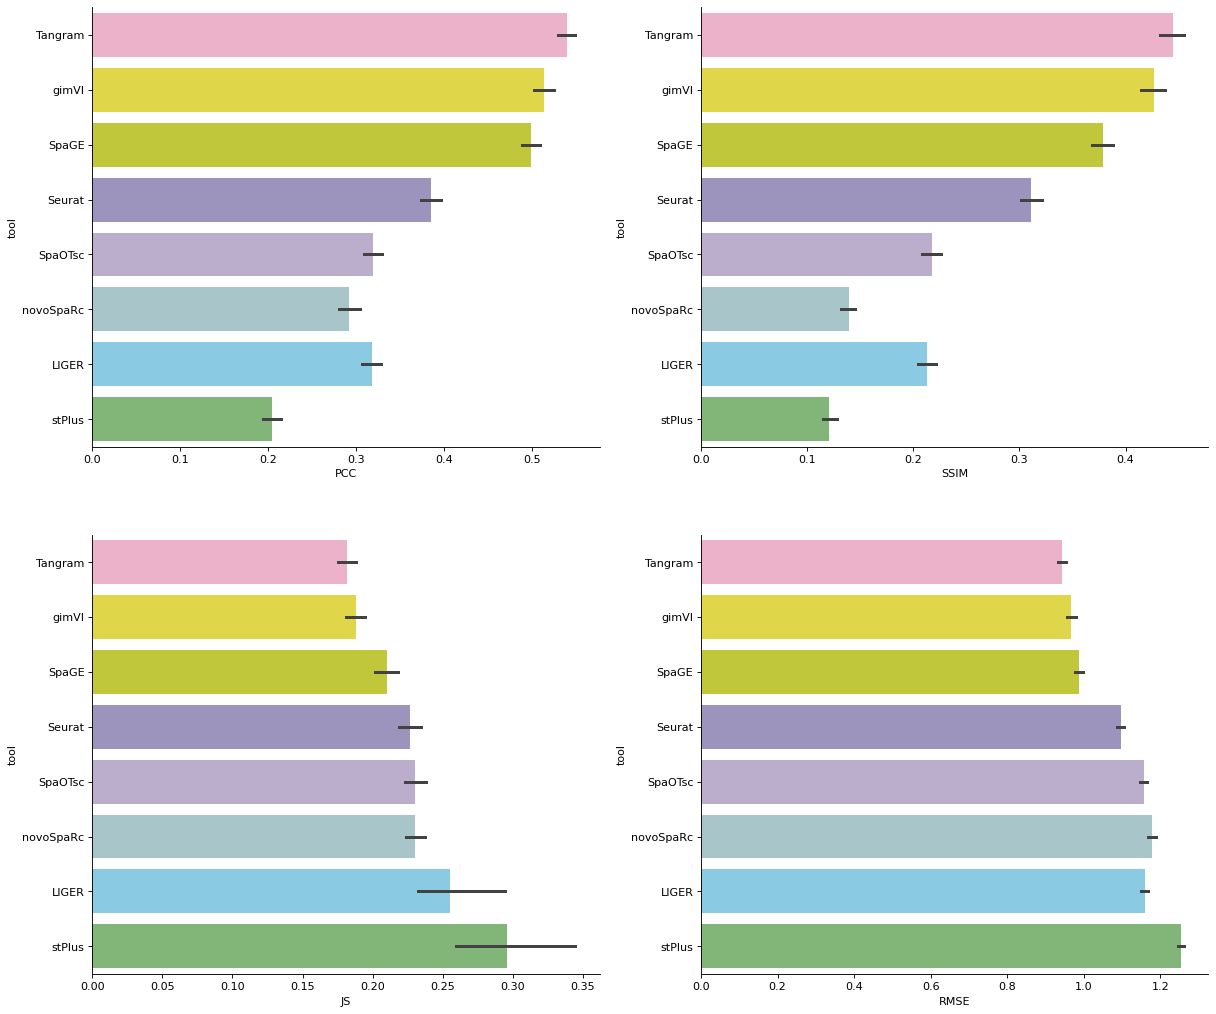

In [49]:
import seaborn as sns
PATH = 'SpatialBenchmarking/FigureData/Figure2/'
metric = ['PCC', 'SSIM', 'JS', 'RMSE']
Data = 'Dataset4'
Tools = ['Tangram', 'gimVI', 'SpaGE', 'Seurat', 'SpaOTsc', 'novoSpaRc', 'LIGER', 'stPlus']
outdir = 'SpatialBenchmarking/FigureData/Figure2/Dataset4/'
if not os.path.exists(outdir):
    os.system('mkdir ' + outdir)
plot_boxplot(PATH, Data, metric,Tools,outdir)




# Calculated Accuracy score for every datasets of each methods

In [62]:
###This script is used for rank get the rank score for each method

def get_score(Result):
    Result = Result.fillna(0)
    tools_num = Result.shape[0]
    Tools_score=[]
    methods = list(Result.index)
    score_col = []
    list_up = list(range(1,Result.shape[1]+1))
    list_down  = list(range(Result.shape[1],0,-1))
    
    for method in methods:
        if method == 'PCC' or method == 'SSIM':
            Tools_score.append(pd.Series(list_down, index=Result.loc[method,:].sort_values(ascending=False).index))
            
        if method == 'JS' or method == 'RMSE':
            Tools_score.append(pd.Series(list_up, index=Result.loc[method,:].sort_values(ascending=False).index))
        score_col.append(method)
        
    score=pd.concat([m for m in Tools_score],axis=1)
    score.columns = score_col
    score = score/Result.shape[1]
    return score

def make_score(dataset_all, Tools, path_output):
    Tools_data=[x for x in range(len(Tools))]
    for dataset in dataset_all:
        RemoveData = {}
        for i in range(len(Tools)):
            File = path + '/' + dataset + '/' + Tools[i] + '_Metrics.txt'
            if os.path.isfile(File): 
                Tools_data[i] = pd.read_table(path + '/' + dataset + '/' + Tools[i] + '_Metrics.txt',sep='\t',index_col=0, header=0)
                Tools_data[i] = Tools_data[i].mean()
                Tools_data[i]['Tool'] = Tools[i]
            else:
                if dataset not in RemoveData:
                    RemoveData[dataset] = []
                RemoveData[dataset].append(Tools[i])
                continue
        Result=pd.concat([m for m in Tools_data], axis=1)
        Result.columns = Result.loc[["Tool"],:].values.flatten()
        Result.drop('Tool', axis = 0, inplace = True)
        
        for D in RemoveData:
            for T in RemoveData[D]:
                Result = Result.drop(T,axis=1)       
            
        score = get_score(Result)
        score.to_csv(path_output + dataset + "_score.txt", header=1, index=1)

path = 'SpatialBenchmarking/FigureData/Figure2/Metrics/'
path_output = 'SpatialBenchmarking/FigureData/Figure2/Metrics/Accuracy_Rank/'
DirFiles = os.listdir(path)
dataset_all = [x for x in DirFiles if x[:4] == 'Data']
dataset_all.insert(0, 'Dataset14')
print (len(dataset_all))
make_score(dataset_all, Tools, path_output)



46


# Accuracy for one datasets

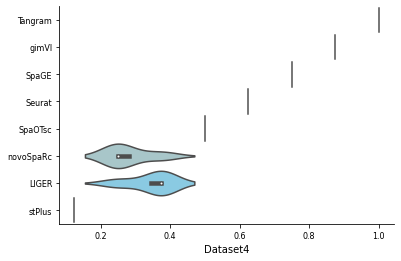

In [63]:
def make_plot_one_dataset(Data,order,palette):
    dataset = pd.read_csv(path + '/Accuracy_Rank/' + Data + '_score.txt', header = 0, index_col = 0)

    dataset_mer = pd.concat([dataset.iloc[:,0],dataset.iloc[:,1],dataset.iloc[:,2],dataset.iloc[:,3]], axis = 0)
    dataset_mer  = pd.DataFrame(dataset_mer,index =dataset_mer.index.values,columns=[Data])
    axes =sns.violinplot(x = Data,y = dataset_mer.index.values, data = dataset_mer ,order = order,palette = palette, width = 0.9)
    axes.set_xlabel(Data, fontsize = 10)
    axes.set_ylabel('', fontsize = 10)
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    plt.xticks(fontsize = 8)
    plt.yticks(fontsize = 8)
    plt.savefig(path + 'Accuracy_Rank/'+ Data + '_violinplot.pdf')
    plt.show()

    
path = 'SpatialBenchmarking/FigureData/Figure2/Metrics/'
dataset='Dataset4'
order = ['Tangram', 'gimVI', 'SpaGE', 'Seurat', 'SpaOTsc', 'novoSpaRc', 'LIGER', 'stPlus']
palette = ["#F5A8C7", '#F9EC31', "#D6DE23", "#988DC3", "#BBA8D1", "#A2CBCF", "#7BD1F1", "#79c06e"]
make_plot_one_dataset(dataset,order,palette)



# Accuracy for image, seq based and all datasets

28
17


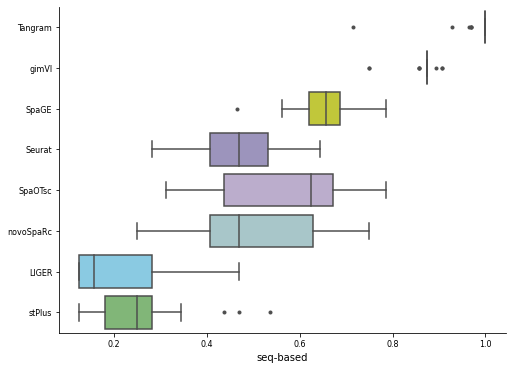

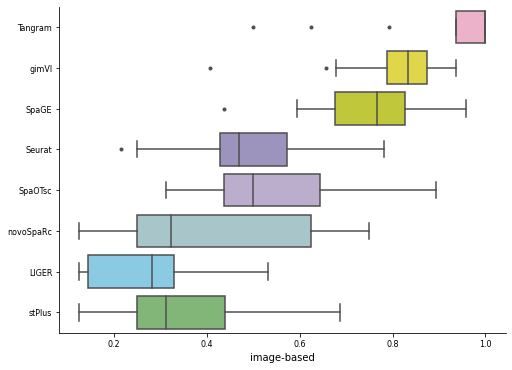

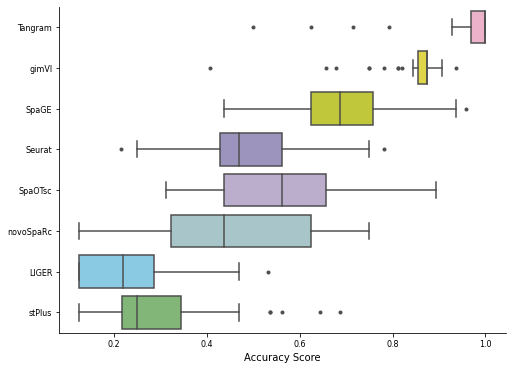

In [66]:

def make_all_score(dataset_all):
    score_all = pd.DataFrame()
    for dataset in dataset_all:
        a = pd.read_csv(path + '/Accuracy_Rank/'+dataset+"_score.txt",header=0,index_col=0)
        score_all=pd.concat([score_all,a],axis=0)
    return score_all


def plot_all(df, name, order, palette):
    df_all = pd.DataFrame(df.sum(axis=1).values,index = df.index.values,columns=['merge'])
    df_all = df_all/4
    
    plt.figure(figsize=(8, 6))
    axes =sns.boxplot(x= 'merge',y= df_all.index.values, data=df_all ,palette=palette,order=order,flierprops = dict(marker='o', markersize=3))
    axes.set_xlabel(name, fontsize=10)
    axes.set_ylabel('', fontsize=10)
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.savefig(path + "/Accuracy_Rank/" + name + '_boxplot.pdf')
    plt.show()

path = 'SpatialBenchmarking/FigureData/Figure2/Metrics/'
os.popen('mkdir ' + path + 'Accuracy_Rank')
path_output = path + '/Accuracy_Rank/'
order = ['Tangram', 'gimVI', 'SpaGE', 'Seurat', 'SpaOTsc', 'novoSpaRc', 'LIGER', 'stPlus']
Tools= ['Tangram', 'gimVI', 'SpaGE', 'Seurat', 'SpaOTsc', 'novoSpaRc', 'LIGER', 'stPlus']
palette = ["#F5A8C7", '#F9EC31', "#D6DE23", "#988DC3", "#BBA8D1", "#A2CBCF", "#7BD1F1", "#79c06e"]
DataSets = os.listdir(path)
DataSets = [x for x in DataSets if x[:4] == 'Data']
image_based_dataset = DataSets[:17]
seq_based_dataset = [x for x in DataSets if x not in image_based_dataset]
print (len(seq_based_dataset))
print (len(image_based_dataset))


image_based = make_all_score(image_based_dataset)
image_based.to_csv(path + "/Accuracy_Rank/image_based_score.txt",header=1, index=1)

seq_based = make_all_score(seq_based_dataset)
seq_based.to_csv(path + "/Accuracy_Rank/seq_based_score.txt",header=1, index=1)

plot_image = pd.read_csv(path + "/Accuracy_Rank/image_based_score.txt",header=0,index_col=0)
plot_seq = pd.read_csv(path + "/Accuracy_Rank/seq_based_score.txt",header=0,index_col=0)

plot_all(plot_seq, 'seq-based', order, palette)
plot_all(plot_image, 'image-based', order, palette)

plot_merge = pd.concat([plot_image,plot_seq],axis=0,join='outer')
plot_merge.to_csv(path + "/Accuracy_Rank/Score.txt", header = 0, index = 0)
plot_all(plot_merge, 'Accuracy Score', order, palette)
